<a href="https://colab.research.google.com/github/Edward-TL/VS_Buy/blob/master/VS_Buy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


In [1]:
from google.colab import drive
drive.mount('/content/drive')

#For the system
import os
from plotly.offline import iplot

#Manage of time
from datetime import datetime, timedelta
from pytz import timezone
import time
import re

#Manage of files
import pandas as pd
import csv

#scrap
from bs4 import BeautifulSoup
from openpyxl.workbook import Workbook
import requests

import plotly

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

In [2]:
from dataclasses import dataclass

@dataclass
class Page:
    name:str
    '''Page URl with name of the format replacers'''
    url : str      
    page_test : str
    '''Tuple with the name of the replacers'''
    url_replacers : tuple
    '''string that will replace the space of the users request on a search'''
    space_replacer : tuple
    '''All the next properties are tuples that contains:
    ("node: span", "attribute: class", "=predicate: text")'''
    boxes : tuple
    '''Products Info'''
    product_urls : tuple
    url_get : str
    # self.product_id = product_id
    name_and_images : tuple
    names_get : str
    images_get : str
    '''All the next properties are tuples that contains:
    ("node: span", "attribute: class", "=predicate: text")'''
    reviews : tuple
    stars : tuple
    price : tuple
    highlights : tuple
    '''dictionary'''
    money_dict : dict
    
    def adapt_url(self, Page, user_request, country_domain):
        check = str(type(Page.url_replacers))
        if country_domain[0] != ".":
            country_domain = '.' + country_domain
        
        
        if check != "<class 'str'>":
            adapted_url = Page.url.replace(Page.url_replacers[0], country_domain)
            for r in range(1, len(Page.url_replacers)):
                user_request_adapted = user_request.replace(' ', Page.space_replacer[r-1])
                adapted_url = adapted_url.replace(Page.url_replacers[r], user_request_adapted)
        else:
            user_request_adapted = user_request.replace(' ', Page.space_replacer[0])
            adapted_url = Page.url.replace(Page.url_replacers, user_request_adapted)
        
        return adapted_url

amazon_money_dict = {'mx' : {'coin' : '$',
                      'thousands': ',',
                      'decimal': '.',
                      'two_prices_sep' : ' - '}
}

Amazon = Page(name = 'Amazon',
    url='https://www.amazon.com{country}/s?k={user_request}',
    page_test='https://www.amazon.com.mx/s?k=audifonos+inalambricos',
    url_replacers=('{country}', '{user_request}'),
    space_replacer=['+'],
    boxes=('div', 'data-component-type', 's-search-result'),
    highlights=('div', 'class', 'a-row a-badge-region'),
    url_get='href',
    product_urls=('a', 'class', 'a-link-normal a-text-normal'),
    name_and_images=('div', 'class', 'a-section aok-relative s-image-square-aspect'),
    names_get='alt',
    images_get='src',
    reviews=('span', 'class', 'a-size-base'),
    stars=('span', 'class', 'a-icon-alt'),
    price=('span', 'class', 'a-offscreen'),
    money_dict=amazon_money_dict,
    #product_id('data-asin')
    )

ebay_money_dict = {'mx' : {'coin' : 'MXN $',
                      'thousands': ' ',
                      'decimal': '.',
                      'two_prices_sep' : ' a '}
            }

Ebay = Page(name='Ebay',
    url='https://www.ebay.com/sch/i.html?_nkw={user_request}',
    page_test='https://www.ebay.com/sch/i.html?_nkw=audifonos+inalambricos',
    url_replacers=('{user_request}'),
    space_replacer=['+'],
    boxes=('li', 'class', 's-item'),
    highlights=('span', 'class', 'ui-search-item__highlight-label__text'),
    product_urls=('div', 'class', 's-item__image'),
    url_get='href',
    name_and_images=('div', 'class', 's-item__image-wrapper'),
    names_get='alt',
    images_get='src',
    reviews=None,
    stars=None,
    price=('span', 'class', 's-item__price'),
    money_dict=ebay_money_dict,)

meli_money_dict = {'mx' : {'coin' : '$',
                      'thousands': ',',
                      'decimal': '.',
                      'two_prices_sep' : ' - '}
            }
            
Mercado_Libre = Page(name='Mercado Libre',
    url='https://listado.mercadolibre.com{country}/{user_request_1}#D[A:{user_request_2}]',
    page_test='https://listado.mercadolibre.com.mx/audifonos-inalambricos#D[A:audifonos%20inalambricos]',
    url_replacers=('{country}', '{user_request_1}', '{user_request_2}'),
    space_replacer=['-','%20'],
    boxes=('div', 'class', 'ui-search-result__wrapper'),
    highlights=('span', 'class', 'ui-search-item__highlight-label__text'),
    product_urls=('div', 'class', 'ui-search-result__image'),
    url_get='href',
    name_and_images=('div', 'class', 'slick-slide slick-active'),
    names_get='alt',
    images_get='data-src',
    reviews=None,
    stars=None,
    price=('span', 'class', 'price-tag ui-search-price__part'),
    money_dict=meli_money_dict,)

# wallmart_money_dict = {'mx' : {'coin' : '$',
#                       'thousands': ',',
#                       'decimal': '.',
#                       'two_prices_sep' : ' - '}
# }

# Wallmart = Page(name = 'Wallmart',
#     url='https://www.walmart.com{country}/productos?Ntt={user_request}',
#     url_replacers=('{country}', '{user_request}'),
#     space_replacer=['%20'],
#     boxes=('div', 'class', 'grid_product__30OQa'),
#     highlights=None,
#     product_urls=('a', 'class', 'nav-link_navLink__2oJ29 product_image__LcsAj'),
#     url_get='href',
#     name_and_images=('span', 'class', 'lazyload-wrapper'),
#     names_get='alt',
#     images_get='src',
#     reviews=None,
#     stars=None,
#     price=('p', 'data-automation-id', 'sale-price'),
#     money_dict=wallmart_money_dict,
#     #product_id('data-asin')
#     )

best_buy_money_dict = {'mx' : {'coin' : '$',
                      'thousands': ',',
                      'decimal': '.',
                      'two_prices_sep' : ' - '}
}

Best_Buy = Page(name = 'Best Buy',
    url='https://www.bestbuy.com{country}/c/buscar-best-buy/buscar?query={user_request}',
    page_test='https://www.bestbuy.com.mx/c/buscar-best-buy/buscar?query=audifonos+inalambricos',
    url_replacers=('{country}', '{user_request}'),
    space_replacer=['+'],
    boxes=('div', 'class', 'product-line-item-line'),
    highlights=None,
    product_urls=('div', 'class', 'product-title'),
    url_get='href',
    name_and_images=('div', 'class', 'col-xs-3 image-container'),
    names_get='alt',
    images_get='src',
    reviews=None,
    stars=None,
    price=('div', 'class', 'product-price'),
    money_dict=best_buy_money_dict,
    #product_id('data-asin')
    )

Pages = [Amazon, Mercado_Libre, Ebay, Best_Buy]

class headers:
    wallmart = {'accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
                'accept-encoding':'gzip, deflate, br',
                'accept-language':'en-GB,en;q=0.9,en-US;q=0.8,ml;q=0.7',
                'cache-control':'max-age=0',
                'upgrade-insecure-requests':'1',
                'user-agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36'}

    h0 = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64;x64; rv:66.0) Gecko/20100101 Firefox/66.0",
            "Accept-Encoding":"gzip, deflate",
            "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
            "DNT":"1",
            "Connection":"close",
            "Upgrade-Insecure-Requests":"1"}

    h1 = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5)AppleWebKit/605.1.15 (KHTML, like Gecko)Version/12.1.1 Safari/605.1.15",
            "Accept-Encoding":"gzip, deflate",
            "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
            "DNT":"1",
            "Connection":"close",
            "Upgrade-Insecure-Requests":"1"}

    h2 = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36",
            "Accept-Encoding":"gzip, deflate",
            "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
            "DNT":"1",
            "Connection":"close",
            "Upgrade-Insecure-Requests":"1"}

    common = (h0, h2, h2)
    h3 = wallmart
    all_saved = (h0, h2, h2, wallmart)

class Products:
    def __init__(self, names, images_links, products_links, prices):
        self.names = names
        self.images = images_links
        self.products_links = products_links
        self.prices = prices

# Scrape Funcs

In [3]:
#Web Manage
from bs4 import BeautifulSoup
import requests
import re

def extract_soup(url, header=0, just_status=False, just_soup=False):
    header = headers.all_saved[header]
    response = requests.get(url, headers=header)
    status = response.status_code

    soup = BeautifulSoup(response.text, 'lxml')

    if just_status==True:
        return status
    elif just_soup==True:
        return soup
    else:
        return soup, status

def search_boxes(soup, box_tuple, cents=False):
    #Search the kind of box specified by the touple
    if cents == True:
        boxes = soup.find(box_tuple[0], attrs={box_tuple[1] : box_tuple[2]})
    else:
        boxes = soup.find_all(box_tuple[0], attrs={box_tuple[1] : box_tuple[2]})

    return boxes

def get_brute_info(boxes_array, info_tuple):
    '''Returns the brute text from the html depending of the info you asked'''
    info = [None]*len(boxes_array)
    searcher = None
    i=0
    for box in boxes_array:
        searcher = search_boxes(box, info_tuple)
        info[i] = searcher
        searcher = None
        i += 1
    
    return info


# Data Filters

In [4]:
import re

def get_names(boxes_array, Page, test_all=False, test_len=False, position=None):
    names = [None]*len(boxes_array)
    name = Page.names_get

    if test_all == True:
            print(f'Boxes array len: {len(boxes_array)}')

    '''If you know want to know some info of an specific product by its position on the page.
    Like you know the position of the cheapest'''
    if position != None:
        searcher = search_boxes(boxes_array[position], Page.name_and_images)
        if searcher:
            if Page.name == 'Best Buy':
                image_name = searcher[0].img.get(name)
                name_split = image_name.split(' - ')
                names = name_split[1]
            else:
                names = searcher[0].img.get(name)
    else:
        '''For Testing the functions and Xpaths'''
        b=0
        if test_all == True:
            print('For Loop')
        for box in boxes_array:
            #Remember that boxes are arrays
            searcher = search_boxes(box, Page.name_and_images)
            if searcher:
                try:
                    if Page.name == 'Best Buy':
                        image_name = searcher[0].img.get(name)
                        name_split = image_name.split(' - ')
                        names[b] = name_split[1]
                    else:
                        names[b] = searcher[0].img.get(name)
                except:
                    name_message_error = f'''Value info:
                    box: {box}
                    Searcher: {searcher}
                    Searcher[0].img = {searcher[0].img}'''

                    raise ValueError(name_message_error)
                
            b +=1
    if test_all == True:
        print(names)
    
    elif test_len == True:
        print(len(names))

    return names


def get_images(boxes_array, Page, test_all=False, test_len=False, position=None):
    images = [None]*len(boxes_array)
    image = Page.images_get
    
    '''If you know want to know some info of an specific product by its position on the page.
    Like you know the position of the cheapest'''
    if position:
        searcher = search_boxes(boxes_array[position], Page.name_and_images)

        if searcher:
            images = searcher[0].img.get(image)
    else:
        '''For Testing the functions and Xpaths'''
        b=0
        for box in boxes_array:
            #Remember that boxes are arrays
            searcher = search_boxes(box, Page.name_and_images)
            if searcher:
                images[b] = searcher[0].img.get(image)
            b +=1

    if test_all == True:
        print(images)
    
    elif test_len == True:
        print('images:', len(images))

    return images

def get_products_urls(boxes_array, Page, test_all=False, test_len=False, position=None):
    urls = [None]*len(boxes_array)
    url = Page.url_get
    if test_all == True:
        print('Urls:')
    '''If you know want to know some info of an specific product by its position on the page.
    Like you know the position of the cheapest'''
    if position:
        searcher = search_boxes(boxes_array[position], Page.product_urls)
        if searcher:
            try:
                if Page.name == 'Amazon':
                    source_url = searcher[0].get(url)
                    position_url = 'https://www.amazon.com.mx' + source_url
                    
                else:
                    position_url = searcher[0].a.get(url)
                
                urls = position_url
            except:
                error_message = f'''Value info:
                Searcher: {searcher}
                searcher[0]: {searcher}
                searcher[0].a: searcher[0].a
                url: {Page.url_get}
                position: {position}
                '''

                raise ValueError(error_message)
    else:
        '''For Testing the functions and Xpaths'''
        b=0
        for box in boxes_array:
            if test_all == True:
                print('For loop:')
            #Remember that boxes are arrays
            searcher = search_boxes(box, Page.product_urls)
            if searcher:
                if test_all == True:
                    print(searcher[0].a)
                if Page.name == 'Amazon':
                    source_url = searcher[0].get(url)
                    urls[b] = 'https://www.amazon.com.mx' + source_url
                    
                else:
                    urls[b] = searcher[0].a.get(url)
            b +=1

    if test_all == True:
        print(urls)
    
    elif test_len == True:
        print('urls:', len(urls))
    return urls

def get_price(country, boxes_array, Page, test_all=False, test_len=False, position=None):
    price = [None]*len(boxes_array)
    coin_symbol = Page.money_dict[country]['coin']
    k_sep = Page.money_dict[country]['thousands']
    d_sep = Page.money_dict[country]['decimal']
    tps = Page.money_dict[country]['two_prices_sep']
    price_string = 'start'

    '''If you know want to know some info of an specific product by its position on the page.
    Like you know the position of the cheapest'''
    if position:
        searcher = search_boxes(boxes_array[position], Page.price)
        if searcher:
            try:
                price_string = searcher[0].get_text().split(tps)
                price_string = price_string[0].replace(coin_symbol,'').replace(k_sep,'').replace(d_sep,'.')
                #Special case
                price_string = re.findall(r'(\d+\.\d+)', price_string)
                price = float(price_string[0])
            except:
                error_message = f'''String index out of range. 
                Money dictionary: {Page.money_dict}
                Original String: {searcher[0].get_text()}
                Box #{position}'''
                raise ValueError(error_message)     
        
    #For Testing the functions and Xpaths
    else:
        b=0
        for box in boxes_array:
            #Remember that boxes are arrays
            searcher = search_boxes(box, Page.price)
            if test_all == True:
                print(searcher)
            if searcher:
                if country == 'mx':
                    try:
                        price_string = searcher[0].get_text().split(tps)
                        if test_all == True:
                            print(price_string)
                        price_string_bfre = price_string[0].replace(coin_symbol,'').replace(k_sep,'').replace(d_sep,'.')
                        if test_all == True:
                            print(price_string) 
                        #Ebays Special case
                        price_string_bfre = price_string_bfre.replace('\xa0','')
                        #Just in case
                        price_string_check = re.findall(rf"(\d+\.?\d+)", price_string_bfre)
                        price[b] = float(price_string_check[0])                        

                    except:
                        error_message = f'''Info about the Value. 
                        Money dictionary: {Page.money_dict}
                        Original String: {searcher[0].get_text()}
                        Before RegEx: {price_string_bfre}
                        Type Before RegEx: {type(price_string)}
                        Price string: {price_string}
                        Box #{b}'''
                        raise ValueError(error_message)                        
            b +=1

    if test_all == True:
        print('prices:', len(price), price)
    
    elif test_len == True:
        print('prices:', len(price))

    return price

def get_stars(boxes_array, Page, country='mx', test_all=False, test_len=False, position=None):
    stars = [None]*len(boxes_array)
    decimal_sep = Page.money_dict[country]['decimal']

    b=0
    for box in boxes_array:
        #Remember that boxes are arrays
        searcher = search_boxes(box, Page.stars)

        if searcher:
            if decimal_sep == '.':
                stars[b] = float(searcher[0].get_text()[:3])
            else:
                stars[b] = float(searcher[0].get_text()[:3].replace(decimal_sep,''))

        b +=1
    if test_all == True:
        print(stars)
    
    elif test_len == True:
        print('stars:', len(stars))
    return stars

def get_reviews(boxes_array, Page, country='mx', test_all=False, test_len=False, position=None):
    reviews = [None]*len(boxes_array)
    comma_sep = Page.money_dict[country]['thousands']

    b=0
    for box in boxes_array:
        #Remember that boxes are arrays
        searcher = search_boxes(box, Page.reviews)

        if searcher:
            if len(searcher) > 1:
                searcher = [searcher[0]]

            try:
                reviews[b] = int(searcher[0].get_text().replace(comma_sep,''))
            except:
                pass
        
        b +=1
    if test_all == True:
        print(reviews)
    
    elif test_len == True:
        print('reviews:', len(reviews))
    return reviews

def amazon_products_id(boxes_array, test=False):
    ids = [None]*len(boxes_array)

    b=0
    for box in boxes_array:
        #Remember that boxes are arrays
        if box:
            product_id = box.get('data-asin')
            ids[b] = 'www.amazon.com.mx/dp/' + product_id
            
        b +=1
    if test == True:
        print(ids)
    return ids

# Cheapest Functions

In [5]:
def ordered_dict(dictionary, reverse=True):
    import operator
    ordered_dict = dict(sorted(dictionary.items(), key=operator.itemgetter(1),reverse=True))

    return ordered_dict

def cheapest(array_prices, just_position=True, just_price=False, position_and_price=False, test=False):
    cheapest_position = 0
    cheapest_price = None
    
    for n in range(len(array_prices)):
        price = array_prices[n]
        if price:
            if cheapest_price == None:
                cheapest_price = price
            if test == True:
                print(f'number = {n} cheapest_price is {cheapest_price} and price check is {price}')

            if price < cheapest_price:
                if test == True:
                    print(f'price: {price} < {cheapest_price}')

                cheapest_price = price
                cheapest_position = n
        
    if position_and_price == True:
        just_position = False
        return cheapest_position, cheapest_price
    elif just_position == True:
        return cheapest_position
    elif just_price == True:
        return cheapest_price


def get_cheapest(cheapest_idx, products, cheapest_price=None, country=None, Page=None):
    products_type = str(type(products))
    if products_type == "<class 'bs4.element.ResultSet'>":
        
        if country and Page:
            cheapest_dict = {}
            cheapest_dict['name'] = get_names(products, Page, position=cheapest_idx)
            cheapest_dict['image'] = get_images(products, Page, position=cheapest_idx)
            cheapest_dict['url'] = get_products_urls(products, Page, position=cheapest_idx)
            cheapest_dict['price'] = cheapest_price
        else:
            if not country:
                raise ValueError("Missing country value")
            elif not Page:
                raise ValueError("Missing Page object")
            elif not cheapest_price:
                raise ValueError("Missing cheapest_price value (int)")
            else:
                raise ValueError(f'''Missing Page and country values.
            You can use this function with a dictionary with all the data preloaded as well''')
            
    elif products_type == "<class 'dict'>":
        cheapest_dict = {}
        products_dictionary = products
        for key in products_dictionary:
            cheapest_dict[key] = products_dictionary[key][cheapest_idx]
    else:
        error_in_product_type =  f"Products type must be a dict or a bs4.element.ResultSet with the boxes. Recived {type(products)}"
        raise ValueError(error_in_product_type)
    
    return cheapest_dict

# Main

In [6]:
def scrap_cheapest(user_request, Page, country='mx'):
    #Adapt the url
    request_url = Page.adapt_url(Page, user_request, country)
    #All the HTML of the page
    soup_request = extract_soup(request_url, 1, just_soup=True)
    # #HTML divided by products, and stored as elements of an array
    page_boxes = search_boxes(soup_request, Page.boxes)
    # From this part, could get better AFTER the 4 scrapers are made
    #From the Boxes, obtain the prices
    price_boxes = get_price(country, page_boxes, Page)
    #Obtain the cheapest from prices and then, you obtain the cheapest product as a dictionary
    cheapest_idx, cheapest_price = cheapest(price_boxes, position_and_price=True)
    cheapest_product_dictionary = get_cheapest(cheapest_idx, page_boxes, cheapest_price, country, Page)

    return cheapest_product_dictionary

In [7]:
user_request = 'audifonos inalambricos'
pages = [Amazon, Mercado_Libre, Ebay, Best_Buy]
for page in pages:
    print(f'Searching {user_request} in -> {page.name}')
    cheapest_dict = scrap_cheapest(user_request, page)
    for key in cheapest_dict:
        print(key,':', cheapest_dict[key])
    print('\n')

Searching audifonos inalambricos in -> Amazon
name : BOBO-Y Audífonos Bluetooth Inalámbricos, Control Táctil y LED Pantalla, Bluetooth 5.0 Auriculares Deportivos IPX7 Impermea...
image : https://m.media-amazon.com/images/I/61pAlPW9iLL._AC_UL320_.jpg
url : https://www.amazon.com.mx/BOBO-Y-Inal%C3%A1mbricos-Auriculares-Deportivos-Impermeable/dp/B07YXVRQR6/ref=sr_1_11?dchild=1&keywords=audifonos+inalambricos&qid=1601424973&sr=8-11
price : 156.0


Searching audifonos inalambricos in -> Mercado Libre
name : Audífonos inalámbricos i7S TWS blanco
image : https://http2.mlstatic.com/D_NQ_NP_702821-MLA43139066623_082020-W.webp
url : https://www.mercadolibre.com.mx/audifonos-inalambricos-i7s-tws-blanco/p/MLM15833648?searchVariation=MLM15833648&source=search#searchVariation=MLM15833648&position=2&type=product&tracking_id=d7a26f73-33fd-4b8f-9e03-bf1418b16eae
price : 129.0


Searching audifonos inalambricos in -> Ebay
name : Inalambricos Bluetooth Audifonos Deportivo Auriculares  estéreo  con micróf

# Name match test

In [8]:
user_request = 'audifonos inalambricos Bluetooth Marshall Major III'
country = 'mx'
def request_products(user_request, Page, country='mx'):
    page_url = Page.adapt_url(Page, user_request, country)

    #All the HTML of the page
    page_soup = extract_soup(page_url, 1, just_soup=True)
    # #HTML divided by products, and stored as elements of an array
    page_boxes = search_boxes(page_soup, Page.boxes)
    # print(page_boxes)
    page_products = {}
    page_products['names'] = get_names(page_boxes, Page)
    # #Best_Buy's images source (link)
    page_products['images'] = get_images(page_boxes, Page)
    page_products['urls'] = get_products_urls(page_boxes, Page)
    page_products['prices'] = get_price(country, page_boxes, Page)

    return page_products

In [9]:
def scrap_cheapest(user_request, Page, country='mx'):
    #Adapt the url
    request_url = Page.adapt_url(Page, user_request, country)
    #All the HTML of the page
    soup_request = extract_soup(request_url, 1, just_soup=True)
    # #HTML divided by products, and stored as elements of an array
    page_boxes = search_boxes(soup_request, Page.boxes)
    # From this part, could get better AFTER the 4 scrapers are made
    #From the Boxes, obtain the prices
    price_boxes = get_price(country, page_boxes, Page)
    #Obtain the cheapest from prices and then, you obtain the cheapest product as a dictionary
    cheapest_idx, cheapest_price = cheapest(price_boxes, position_and_price=True)
    cheapest_product_dictionary = get_cheapest(cheapest_idx, page_boxes, cheapest_price, country, Page)

    return cheapest_product_dictionary

In [10]:
import unicodedata
def standarize(word):
    word = word.lower()
    word = unicodedata.normalize('NFKD', word).encode('ASCII', 'ignore')
    return word

def name_hits(user_request, product_names_array, array=True, dictionary=False):
    request_splited = user_request.split()
    if dictionary == True:
        hits_dict = {}
    if array == True:
        hits_array = []

    for product_name in product_names_array:
        points = 0
        product_splited = product_name.split()

        n = 0
        word = request_splited[n]
        for split in product_splited:
            split = standarize(split)
            while word != split and n < len(request_splited):
                word = standarize(request_splited[n])

                if word == split:
                    points += 1
                n += 1
            n = 0
        if dictionary == True:
            hits_dict[product_name] = points/len(request_splited)
        if array == True:
            hits_array.append(points/len(request_splited))

    if dictionary == True and array == False:
        return hits_dict
    elif array == True and dictionary == False:
        return hits_array
    else:
        return hits_dict, hits_array



# Data landing

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from plotly.offline import iplot
import plotly.graph_objs as go

In [12]:
def graph_texts(product_dict):
    texts = []
    for n in range(len(product_dict['names'])):
        text = f'''Product: {product_dict['names'][n]}
url: {product_dict['urls'][n]}
price: {product_dict['prices'][n]}
%hits: {product_dict['%hits'][n]}'''
        texts.append(text)
    return texts

In [13]:
best_buy_products = request_products(user_request, Best_Buy)

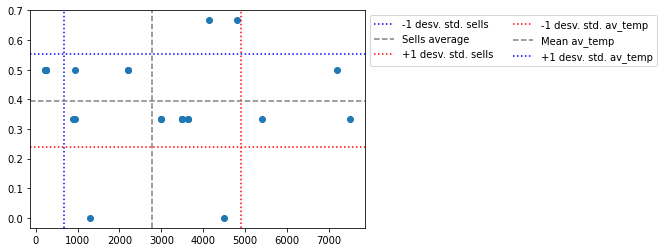

In [14]:
product_names_array = best_buy_products['names']
hits_array = name_hits(user_request, product_names_array)

x = best_buy_products['prices']
y = hits_array

plt.scatter(x, y)

plt.axvline(np.mean(x)-np.std(x), c = 'b', linestyle = ':', label = '-1 desv. std. sells')
plt.axvline(np.mean(x), c = 'grey', linestyle = '--', label = 'Sells average')
plt.axvline(np.mean(x)+np.std(x), c = 'r', linestyle = ':', label = '+1 desv. std. sells')

plt.axhline(np.mean(y)-np.std(y), c = 'r', linestyle = ':', label = '-1 desv. std. av_temp')
plt.axhline(np.mean(y), c = 'grey', linestyle = '--', label = 'Mean av_temp')
plt.axhline(np.mean(y)+np.std(y), c = 'b', linestyle = ':', label = '+1 desv. std. av_temp')

plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=2)

plt.show()


In [48]:
def add_clasification_info(products_dict, colors_dict, cheapest_idx):
    x = products_dict['prices']
    y = products_dict['%hits']

    price_std_plus = np.mean(x) + np.std(x)
    price_mean = np.mean(x)
    price_std_less = np.mean(x) - np.std(x)
    hits_std_plus = np.mean(y) + np.std(y)
    hits_mean = np.mean(y)
    hits_std_less = np.mean(y) - np.std(y)

    colors = ['None'] * len(products_dict['names'])
    clasification = ['None'] * len(products_dict['names'])
    sizes = [15] * len(products_dict['names'])

    cheapest_stock = {'Desireable': [None, None],
                      'Expensive but Requested': [None, None],
                      "Couldn't find better": [None, None],
                      'Emergency Case': [None, None],
                      }

    for product in range(len(products_dict['names'])):
        if product == cheapest_idx:
            category = 'cheep_idx_choose'
            sizes[product] = 30
        else:
            price = products_dict['prices'][product]
            hit = products_dict['%hits'][product]
            if price >= price_mean and price <= price_std_plus:
                if hit >= hits_std_plus:
                    category = 'Expensive but Requested'

                elif hit >= hits_mean and hit <= hits_std_plus:
                    category = 'Emergency Case'

                elif hit <= hits_mean:
                    category = "Ignored"

            elif price <= price_mean and price >= price_std_less:
                if hit >= hits_std_plus:
                    category = 'Desireable'

                elif hit >= hits_mean and hit <= hits_std_plus:
                    category = "Couldn't find better"

                elif hit <= hits_mean:
                    category = "Ignored"
            else:
                category = "Ignored"

        if category != "Ignored" and category != 'cheep_idx_choose':
            stock_price = cheapest_stock[category][0]
            stock_cat_idx = cheapest_stock[category][1]

            if stock_price == None:
                cheapest_stock[category][0] = price
                cheapest_stock[category][1] = product
            else:
                if price < stock_price:
                    cheapest_stock[category][0] = price
                    cheapest_stock[category][1] = product
        
        clasification[product] = category
        colors[product] = colors_dict[category]

    if cheapest_stock['Desireable'][0] != None:
        chosen_area = 'Desireable'
    else:
        if cheapest_stock['Expensive but Requested'][0] != None:
            chosen_area = 'Expensive but Requested'
        else:
            if cheapest_stock["Couldn't find better"][0] != None:
                chosen_area = "Couldn't find better"
            else:
                chosen_area = 'Emergency Case'
    
    areas_choose_product = cheapest_stock[chosen_area][1]

    clasification[areas_choose_product] = 'areas_choose'
    colors[areas_choose_product] = colors_dict['areas_choose']
    sizes[areas_choose_product] = 30

    products_dict['price_std_plus'] = price_std_plus
    products_dict['price_mean'] = price_mean
    products_dict['price_std_less'] = price_std_less
    products_dict['hits_std_plus'] = hits_std_plus
    products_dict['hits_mean'] = hits_mean
    products_dict['hits_std_less'] = hits_std_less
    products_dict['colors'] = colors
    products_dict['clasification'] = clasification
    products_dict['sizes'] = sizes
    products_dict['cheapest_stock'] = cheapest_stock

    return products_dict

# Graph

In [21]:
def test_plot(products_dict, rect_opacity=0.3):
    trace = go.Scatter(
        x = products_dict['prices'],
        y = products_dict['%hits'],
        text = products_dict['names'],
        mode = 'markers',
        name = 'Results of web Scraper',
        marker = dict(color = products_dict['colors'],
                      size = products_dict['sizes'])
    )

    price_std_plus = products_dict['price_std_plus']
    price_mean = products_dict['price_mean']
    price_std_less = products_dict['price_std_less']
    hits_std_plus = products_dict['hits_std_plus']
    hits_mean = products_dict['hits_mean']
    hits_std_less = products_dict['hits_std_less']
    colors = products_dict['colors']
    clasification = products_dict['clasification']

    layout = {
        'title' : 'Relevance vs Price',
        'xaxis_title' : 'Price MXN',
        'yaxis_title' : '%Hits',
        'shapes': [
            # Rectangule one
            dict(
                type = "rect", xref = "x", yref = "y",
                x0 = price_std_less, y0 = hits_std_plus,
                x1 = price_mean, y1 = 1,
                opacity = rect_opacity, fillcolor = "LightSkyBlue", layer = 'below', line_width = 0
            ),
            # Rectangule two
            dict(
                type = "rect", xref = "x", yref = "y",
                x0 = price_mean, y0 = hits_std_plus,
                x1 = price_std_plus, y1 = 1,
                opacity = rect_opacity, fillcolor = "DarkCyan", layer = 'below', line_width = 0
            ),
            dict(
                type = "rect", xref = "x", yref = "y",
                x0 = price_std_less, y0 = hits_std_plus,
                x1 = price_mean, y1 = hits_mean,
                opacity = rect_opacity, fillcolor = "DarkKhaki", layer = 'below', line_width = 0
            ),
            # Rectangule two
            dict(
                type = "rect", xref = "x", yref = "y",
                x0 = price_mean, y0 = hits_std_plus,
                x1 = price_std_plus, y1 = hits_mean,
                opacity = rect_opacity, fillcolor = "DarkRed", layer = 'below', line_width = 0
            )
        ],
    }

    x_mean_left = (price_std_less + price_mean) /2
    x_mean_right = (price_mean + price_std_plus) /2

    y_mean_up = (1 + hits_std_plus) / 2
    y_mean_down = (hits_std_plus + hits_mean)/2
    
    rect_labels = go.Scatter(
        x = [x_mean_left, x_mean_right, x_mean_left, x_mean_right],
        y = [y_mean_up, y_mean_up, y_mean_down, y_mean_down],
        text = ['Desireable', "Expensive & Requested", "Couldn't find better", "Emergency Case"],
        mode = 'text',
        name = 'Safe Areas'
    )

    fig = {
        'data': [trace, rect_labels],
        'layout': layout,
    }


    iplot(fig)

In [55]:
user_request = 'pantalla plana'
best_buy_products = request_products(user_request, Best_Buy)
best_buy_products['%hits'] = name_hits(user_request, product_names_array)
best_buy_products['texts'] = graph_texts(best_buy_products)

cheapest_idx = cheapest(best_buy_products['prices'])

colors_dict = {'Ignored' : 'Black',
               'cheep_idx_choose' : 'DarkGoldenRod',
               'areas_choose':'LawnGreen',
               'cheap_choose' : 'Magenta',
                'Desireable': 'Blue',
                "Expensive but Requested": 'Green',
                "Couldn't find better": 'Gold',
                "Emergency Case": 'Crimson'
                }

best_buy_products = add_clasification_info(best_buy_products, colors_dict, cheapest_idx)
test_plot(best_buy_products)